In [1]:
from PIL import Image

image = Image.open("/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM NEW NEW/RESM/20100903_0025_hr_patch_11.jpg")
mode = image.mode
channels = {"L": 1, "RGB": 3, "RGBA": 4, "CMYK": 4}  # Mapping for common modes
num_channels = channels.get(mode, "Unknown")
print(f"Number of channels: {num_channels}")


Number of channels: 1


In [2]:
import os 
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split
import random
from datetime import datetime


from loop import train_loop
from dcnet import DCNet

/home/user/miniforge3/envs/pytorch/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, lr_transform=None, hr_transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = os.listdir(lr_dir)
        self.lr_transform = lr_transform
        self.hr_transform = hr_transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_image_path = os.path.join(self.hr_dir, self.lr_images[idx])

        lr_image = Image.open(lr_image_path).convert("L").resize((64, 64))  # Resize to 64x64
        hr_image = Image.open(hr_image_path).convert("L").resize((256, 256))  # Resize to 256x256

        if self.lr_transform:
            lr_image = self.lr_transform(lr_image)
        if self.hr_transform:
            hr_image = self.hr_transform(hr_image)

        return {'image': lr_image, 'label': hr_image}

In [4]:
def dataloaders(train_dataset, val_dataset, batch_size=8, num_train_samples=None, num_val_samples=None):
    """
    Create dataloaders for training and validation datasets with an optional limit 
    on the number of samples to use.

    Args:
        train_dataset: The training dataset.
        val_dataset: The validation dataset.
        batch_size: The batch size for the dataloaders.
        num_train_samples: The number of samples to use from the training dataset. If None, use all samples.
        num_val_samples: The number of samples to use from the validation dataset. If None, use all samples.

    Returns:
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
    """
    # Limit the number of samples if specified
    if num_train_samples is not None:
        train_dataset, _ = torch.utils.data.random_split(train_dataset, [num_train_samples, len(train_dataset) - num_train_samples])
    if num_val_samples is not None:
        val_dataset, _ = torch.utils.data.random_split(val_dataset, [num_val_samples, len(val_dataset) - num_val_samples])

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


def setup_training(model, device, train_loader, val_loader, epochs=500, patience=10):
    # Ensure the model is moved to the correct device
    model = model.to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999))

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 45, 65, 85], gamma=0.5)

    # Initialize loss function
    criterion = nn.L1Loss()

    # Prepare output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join("models", timestamp)
    os.makedirs(output_dir, exist_ok=True)

    # Start training loop
    train_loop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=epochs
    )


In [5]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is being used. Device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU instead of GPU.")

GPU is being used. Device: NVIDIA RTX A6000


In [6]:
from torchinfo import summary


CUDA is available!
Number of available GPUs: 1
Current device: 0
Device name: NVIDIA RTX A6000


/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/anubhav/DCNET/Resolution_Enhancement_DCNET-main/Resolution_Enhancement_DCNET/Architecture/loop.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Train Epoch 1/500:   0%|          | 0/1047 [00:00<?, ?it/s]/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/anubhav/DCNET/Resolution_Enhancement_DCNET-main/Resolution_Enhancement_DCNET/Architecture/loop.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val Epoch 1/500:   0%|          | 0/262 [00:00<?, ?it/s]                           /media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/anubhav/DCNET/Resolution_Enhancement_DCNET-main/Resolution_Enhancement_DCNET/Architecture/loop.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocas

Epoch 1/500  Loss: 3.7812  PSNR: 24.3681  SSIM: 0.5974  RMSE: 0.0605  PCC: 0.8491


Epoch 2/500  Loss: 2.6716  PSNR: 24.3443  SSIM: 0.5992  RMSE: 0.0607  PCC: 0.8493


Epoch 3/500  Loss: 1.9395  PSNR: 24.2308  SSIM: 0.5986  RMSE: 0.0615  PCC: 0.8482


Epoch 4/500  Loss: 1.3378  PSNR: 24.5430  SSIM: 0.6004  RMSE: 0.0593  PCC: 0.8510


Epoch 5/500  Loss: 0.8307  PSNR: 24.5474  SSIM: 0.6012  RMSE: 0.0593  PCC: 0.8511


Epoch 6/500  Loss: 0.3971  PSNR: 24.6190  SSIM: 0.6022  RMSE: 0.0588  PCC: 0.8535


Epoch 7/500  Loss: 0.0228  PSNR: 24.6688  SSIM: 0.6035  RMSE: 0.0584  PCC: 0.8545


Epoch 8/500  Loss: -0.3035  PSNR: 24.7239  SSIM: 0.6039  RMSE: 0.0581  PCC: 0.8547


Epoch 9/500  Loss: -0.5891  PSNR: 24.7790  SSIM: 0.6053  RMSE: 0.0577  PCC: 0.8547


Epoch 10/500  Loss: -0.8440  PSNR: 24.8883  SSIM: 0.6071  RMSE: 0.0570  PCC: 0.8569


Epoch 11/500  Loss: -1.0750  PSNR: 24.9834  SSIM: 0.6083  RMSE: 0.0564  PCC: 0.8569


Epoch 12/500  Loss: -1.2921  PSNR: 25.0741  SSIM: 0.6094  RMSE: 0.0558  PCC: 0.8599


Epoch 13/500  Loss: -1.5016  PSNR: 25.1430  SSIM: 0.6102  RMSE: 0.0553  PCC: 0.8609


Epoch 14/500  Loss: -1.7073  PSNR: 25.1492  SSIM: 0.6119  RMSE: 0.0553  PCC: 0.8596


Epoch 15/500  Loss: -1.9108  PSNR: 25.2550  SSIM: 0.6126  RMSE: 0.0546  PCC: 0.8620


Epoch 16/500  Loss: -2.1113  PSNR: 25.2903  SSIM: 0.6127  RMSE: 0.0544  PCC: 0.8629


Epoch 17/500  Loss: -2.3099  PSNR: 25.3002  SSIM: 0.6152  RMSE: 0.0543  PCC: 0.8624


Epoch 18/500  Loss: -2.5029  PSNR: 25.4172  SSIM: 0.6164  RMSE: 0.0536  PCC: 0.8654


Epoch 19/500  Loss: -2.6917  PSNR: 25.4493  SSIM: 0.6161  RMSE: 0.0534  PCC: 0.8650


Epoch 20/500  Loss: -2.8750  PSNR: 25.5595  SSIM: 0.6164  RMSE: 0.0528  PCC: 0.8675


Epoch 21/500  Loss: -3.0517  PSNR: 25.5207  SSIM: 0.6166  RMSE: 0.0530  PCC: 0.8667


Epoch 22/500  Loss: -3.2192  PSNR: 25.6020  SSIM: 0.6171  RMSE: 0.0525  PCC: 0.8687


Epoch 23/500  Loss: -3.3741  PSNR: 25.5678  SSIM: 0.6183  RMSE: 0.0527  PCC: 0.8699


Epoch 24/500  Loss: -3.5205  PSNR: 25.7077  SSIM: 0.6170  RMSE: 0.0519  PCC: 0.8710


Epoch 25/500  Loss: -3.6507  PSNR: 25.7787  SSIM: 0.6195  RMSE: 0.0514  PCC: 0.8729


Epoch 26/500  Loss: -3.7614  PSNR: 25.8334  SSIM: 0.6199  RMSE: 0.0511  PCC: 0.8737


Epoch 27/500  Loss: -3.8286  PSNR: 25.8357  SSIM: 0.6203  RMSE: 0.0511  PCC: 0.8737


Epoch 28/500  Loss: -3.8841  PSNR: 25.8880  SSIM: 0.6205  RMSE: 0.0508  PCC: 0.8750


Epoch 29/500  Loss: -3.9350  PSNR: 25.9147  SSIM: 0.6215  RMSE: 0.0507  PCC: 0.8758


Epoch 30/500  Loss: -3.9797  PSNR: 25.9062  SSIM: 0.6210  RMSE: 0.0507  PCC: 0.8754


Epoch 31/500  Loss: -4.0174  PSNR: 25.9433  SSIM: 0.6198  RMSE: 0.0505  PCC: 0.8762


Epoch 32/500  Loss: -4.0509  PSNR: 25.9098  SSIM: 0.6201  RMSE: 0.0507  PCC: 0.8758


Epoch 33/500  Loss: -4.0775  PSNR: 25.9687  SSIM: 0.6201  RMSE: 0.0503  PCC: 0.8770


Epoch 34/500  Loss: -4.0959  PSNR: 25.9965  SSIM: 0.6193  RMSE: 0.0502  PCC: 0.8777


Epoch 35/500  Loss: -4.1093  PSNR: 25.9916  SSIM: 0.6183  RMSE: 0.0502  PCC: 0.8775


Epoch 36/500  Loss: -4.1185  PSNR: 26.0004  SSIM: 0.6186  RMSE: 0.0502  PCC: 0.8775


Epoch 37/500  Loss: -4.1232  PSNR: 26.0100  SSIM: 0.6185  RMSE: 0.0501  PCC: 0.8782


Epoch 38/500  Loss: -4.1220  PSNR: 25.9858  SSIM: 0.6192  RMSE: 0.0503  PCC: 0.8776


Epoch 39/500  Loss: -4.1276  PSNR: 26.0272  SSIM: 0.6186  RMSE: 0.0500  PCC: 0.8784


Epoch 40/500  Loss: -4.1327  PSNR: 25.9867  SSIM: 0.6186  RMSE: 0.0502  PCC: 0.8775


Epoch 41/500  Loss: -4.1345  PSNR: 26.0065  SSIM: 0.6199  RMSE: 0.0501  PCC: 0.8780


Epoch 42/500  Loss: -4.1333  PSNR: 26.0414  SSIM: 0.6207  RMSE: 0.0499  PCC: 0.8792


Epoch 43/500  Loss: -4.1428  PSNR: 26.0292  SSIM: 0.6219  RMSE: 0.0500  PCC: 0.8790


Epoch 44/500  Loss: -4.1440  PSNR: 26.0476  SSIM: 0.6217  RMSE: 0.0499  PCC: 0.8791


Epoch 45/500  Loss: -4.1486  PSNR: 26.0606  SSIM: 0.6196  RMSE: 0.0498  PCC: 0.8793


Epoch 46/500  Loss: -4.1704  PSNR: 26.1035  SSIM: 0.6233  RMSE: 0.0496  PCC: 0.8804


Epoch 47/500  Loss: -4.1837  PSNR: 26.1077  SSIM: 0.6245  RMSE: 0.0496  PCC: 0.8806


Epoch 48/500  Loss: -4.1869  PSNR: 26.0943  SSIM: 0.6251  RMSE: 0.0496  PCC: 0.8803


Epoch 49/500  Loss: -4.1903  PSNR: 26.0974  SSIM: 0.6250  RMSE: 0.0496  PCC: 0.8803


Epoch 50/500  Loss: -4.1935  PSNR: 26.1047  SSIM: 0.6246  RMSE: 0.0496  PCC: 0.8805


Epoch 51/500  Loss: -4.1989  PSNR: 26.1094  SSIM: 0.6250  RMSE: 0.0496  PCC: 0.8807


Epoch 52/500  Loss: -4.2005  PSNR: 26.1221  SSIM: 0.6254  RMSE: 0.0495  PCC: 0.8810


Epoch 53/500  Loss: -4.2027  PSNR: 26.1289  SSIM: 0.6260  RMSE: 0.0494  PCC: 0.8812


Epoch 54/500  Loss: -4.2065  PSNR: 26.1070  SSIM: 0.6264  RMSE: 0.0496  PCC: 0.8809


Epoch 55/500  Loss: -4.2059  PSNR: 26.1138  SSIM: 0.6258  RMSE: 0.0495  PCC: 0.8807


Epoch 56/500  Loss: -4.2078  PSNR: 26.1092  SSIM: 0.6262  RMSE: 0.0496  PCC: 0.8807


Epoch 57/500  Loss: -4.2055  PSNR: 26.1266  SSIM: 0.6260  RMSE: 0.0495  PCC: 0.8811


Epoch 58/500  Loss: -4.2120  PSNR: 26.1299  SSIM: 0.6258  RMSE: 0.0494  PCC: 0.8812


Epoch 59/500  Loss: -4.2159  PSNR: 26.1240  SSIM: 0.6258  RMSE: 0.0495  PCC: 0.8810


Epoch 60/500  Loss: -4.2172  PSNR: 26.1361  SSIM: 0.6267  RMSE: 0.0494  PCC: 0.8814


Epoch 61/500  Loss: -4.2191  PSNR: 26.1446  SSIM: 0.6266  RMSE: 0.0494  PCC: 0.8816


Epoch 62/500  Loss: -4.2207  PSNR: 26.1252  SSIM: 0.6273  RMSE: 0.0495  PCC: 0.8811


Epoch 63/500  Loss: -4.2224  PSNR: 26.1335  SSIM: 0.6267  RMSE: 0.0494  PCC: 0.8813


Epoch 64/500  Loss: -4.2280  PSNR: 26.1456  SSIM: 0.6271  RMSE: 0.0494  PCC: 0.8817


Epoch 65/500  Loss: -4.2258  PSNR: 26.1498  SSIM: 0.6272  RMSE: 0.0493  PCC: 0.8817


Epoch 66/500  Loss: -4.2413  PSNR: 26.1618  SSIM: 0.6276  RMSE: 0.0493  PCC: 0.8820


Epoch 67/500  Loss: -4.2415  PSNR: 26.1641  SSIM: 0.6276  RMSE: 0.0493  PCC: 0.8821


Epoch 68/500  Loss: -4.2472  PSNR: 26.1685  SSIM: 0.6280  RMSE: 0.0492  PCC: 0.8822


Epoch 69/500  Loss: -4.2487  PSNR: 26.1633  SSIM: 0.6284  RMSE: 0.0493  PCC: 0.8821


Epoch 70/500  Loss: -4.2437  PSNR: 26.1571  SSIM: 0.6280  RMSE: 0.0493  PCC: 0.8819


Epoch 71/500  Loss: -4.2470  PSNR: 26.1672  SSIM: 0.6282  RMSE: 0.0492  PCC: 0.8822


Epoch 72/500  Loss: -4.2531  PSNR: 26.1685  SSIM: 0.6278  RMSE: 0.0492  PCC: 0.8822


Epoch 73/500  Loss: -4.2505  PSNR: 26.1610  SSIM: 0.6283  RMSE: 0.0493  PCC: 0.8821


Epoch 74/500  Loss: -4.2510  PSNR: 26.1670  SSIM: 0.6281  RMSE: 0.0492  PCC: 0.8821


Epoch 75/500  Loss: -4.2528  PSNR: 26.1798  SSIM: 0.6281  RMSE: 0.0492  PCC: 0.8825


Epoch 76/500  Loss: -4.2546  PSNR: 26.1689  SSIM: 0.6283  RMSE: 0.0492  PCC: 0.8822


Epoch 77/500  Loss: -4.2568  PSNR: 26.1701  SSIM: 0.6283  RMSE: 0.0492  PCC: 0.8822


Epoch 78/500  Loss: -4.2537  PSNR: 26.1696  SSIM: 0.6288  RMSE: 0.0492  PCC: 0.8823


Epoch 79/500  Loss: -4.2563  PSNR: 26.1827  SSIM: 0.6281  RMSE: 0.0491  PCC: 0.8826


Epoch 80/500  Loss: -4.2581  PSNR: 26.1718  SSIM: 0.6286  RMSE: 0.0492  PCC: 0.8823


Epoch 81/500  Loss: -4.2542  PSNR: 26.1726  SSIM: 0.6285  RMSE: 0.0492  PCC: 0.8824


Epoch 82/500  Loss: -4.2583  PSNR: 26.1805  SSIM: 0.6286  RMSE: 0.0492  PCC: 0.8825


Epoch 83/500  Loss: -4.2599  PSNR: 26.1816  SSIM: 0.6284  RMSE: 0.0492  PCC: 0.8825


Epoch 84/500  Loss: -4.2637  PSNR: 26.1806  SSIM: 0.6286  RMSE: 0.0492  PCC: 0.8825


Epoch 85/500  Loss: -4.2611  PSNR: 26.1851  SSIM: 0.6286  RMSE: 0.0491  PCC: 0.8826


Epoch 86/500  Loss: -4.2692  PSNR: 26.1863  SSIM: 0.6289  RMSE: 0.0491  PCC: 0.8826


Epoch 87/500  Loss: -4.2711  PSNR: 26.1849  SSIM: 0.6292  RMSE: 0.0491  PCC: 0.8826


Epoch 88/500  Loss: -4.2692  PSNR: 26.1843  SSIM: 0.6293  RMSE: 0.0491  PCC: 0.8826


Epoch 89/500  Loss: -4.2706  PSNR: 26.1866  SSIM: 0.6292  RMSE: 0.0491  PCC: 0.8827


Epoch 90/500  Loss: -4.2683  PSNR: 26.1866  SSIM: 0.6291  RMSE: 0.0491  PCC: 0.8826


Epoch 91/500  Loss: -4.2749  PSNR: 26.1868  SSIM: 0.6292  RMSE: 0.0491  PCC: 0.8826


Epoch 92/500  Loss: -4.2747  PSNR: 26.1820  SSIM: 0.6292  RMSE: 0.0492  PCC: 0.8825


Epoch 93/500  Loss: -4.2719  PSNR: 26.1853  SSIM: 0.6293  RMSE: 0.0491  PCC: 0.8826


Epoch 94/500  Loss: -4.2709  PSNR: 26.1894  SSIM: 0.6291  RMSE: 0.0491  PCC: 0.8827


Epoch 95/500  Loss: -4.2755  PSNR: 26.1902  SSIM: 0.6290  RMSE: 0.0491  PCC: 0.8827


Epoch 96/500  Loss: -4.2751  PSNR: 26.1899  SSIM: 0.6292  RMSE: 0.0491  PCC: 0.8828


Epoch 97/500  Loss: -4.2758  PSNR: 26.1906  SSIM: 0.6293  RMSE: 0.0491  PCC: 0.8827


Epoch 98/500  Loss: -4.2775  PSNR: 26.1893  SSIM: 0.6292  RMSE: 0.0491  PCC: 0.8827


Epoch 99/500  Loss: -4.2776  PSNR: 26.1918  SSIM: 0.6293  RMSE: 0.0491  PCC: 0.8828


Epoch 100/500  Loss: -4.2787  PSNR: 26.1897  SSIM: 0.6295  RMSE: 0.0491  PCC: 0.8828


Epoch 101/500  Loss: -4.2797  PSNR: 26.1898  SSIM: 0.6294  RMSE: 0.0491  PCC: 0.8828


Epoch 102/500  Loss: -4.2792  PSNR: 26.1832  SSIM: 0.6297  RMSE: 0.0492  PCC: 0.8826


Epoch 103/500  Loss: -4.2763  PSNR: 26.1923  SSIM: 0.6295  RMSE: 0.0491  PCC: 0.8828


Epoch 104/500  Loss: -4.2796  PSNR: 26.1979  SSIM: 0.6294  RMSE: 0.0491  PCC: 0.8829


Epoch 105/500  Loss: -4.2814  PSNR: 26.1896  SSIM: 0.6296  RMSE: 0.0491  PCC: 0.8827


Epoch 106/500  Loss: -4.2765  PSNR: 26.1918  SSIM: 0.6294  RMSE: 0.0491  PCC: 0.8828


Epoch 107/500  Loss: -4.2801  PSNR: 26.1885  SSIM: 0.6296  RMSE: 0.0491  PCC: 0.8827


Epoch 108/500  Loss: -4.2821  PSNR: 26.1967  SSIM: 0.6293  RMSE: 0.0491  PCC: 0.8829


Epoch 109/500  Loss: -4.2823  PSNR: 26.1927  SSIM: 0.6296  RMSE: 0.0491  PCC: 0.8828


Epoch 110/500  Loss: -4.2814  PSNR: 26.1958  SSIM: 0.6295  RMSE: 0.0491  PCC: 0.8829


Epoch 111/500  Loss: -4.2783  PSNR: 26.1910  SSIM: 0.6296  RMSE: 0.0491  PCC: 0.8828


Epoch 112/500  Loss: -4.2821  PSNR: 26.1959  SSIM: 0.6295  RMSE: 0.0491  PCC: 0.8829


Epoch 113/500  Loss: -4.2812  PSNR: 26.1944  SSIM: 0.6296  RMSE: 0.0491  PCC: 0.8829


Epoch 114/500  Loss: -4.2821  PSNR: 26.1911  SSIM: 0.6299  RMSE: 0.0491  PCC: 0.8828


Epoch 115/500  Loss: -4.2823  PSNR: 26.1959  SSIM: 0.6298  RMSE: 0.0491  PCC: 0.8829


Epoch 116/500  Loss: -4.2835  PSNR: 26.1960  SSIM: 0.6297  RMSE: 0.0491  PCC: 0.8829


Epoch 117/500  Loss: -4.2840  PSNR: 26.1957  SSIM: 0.6297  RMSE: 0.0491  PCC: 0.8829


Epoch 118/500  Loss: -4.2830  PSNR: 26.1927  SSIM: 0.6299  RMSE: 0.0491  PCC: 0.8828


Epoch 119/500  Loss: -4.2840  PSNR: 26.2023  SSIM: 0.6296  RMSE: 0.0490  PCC: 0.8831


Epoch 120/500  Loss: -4.2876  PSNR: 26.1964  SSIM: 0.6298  RMSE: 0.0491  PCC: 0.8829


Epoch 121/500  Loss: -4.2816  PSNR: 26.2020  SSIM: 0.6298  RMSE: 0.0490  PCC: 0.8831


Epoch 122/500  Loss: -4.2870  PSNR: 26.1982  SSIM: 0.6299  RMSE: 0.0491  PCC: 0.8830


Epoch 123/500  Loss: -4.2850  PSNR: 26.1981  SSIM: 0.6298  RMSE: 0.0491  PCC: 0.8829


Epoch 124/500  Loss: -4.2834  PSNR: 26.2004  SSIM: 0.6299  RMSE: 0.0491  PCC: 0.8830


Epoch 125/500  Loss: -4.2895  PSNR: 26.1950  SSIM: 0.6301  RMSE: 0.0491  PCC: 0.8829


Epoch 126/500  Loss: -4.2887  PSNR: 26.1997  SSIM: 0.6299  RMSE: 0.0491  PCC: 0.8830


Epoch 127/500  Loss: -4.2871  PSNR: 26.2025  SSIM: 0.6298  RMSE: 0.0490  PCC: 0.8830


Epoch 128/500  Loss: -4.2878  PSNR: 26.1981  SSIM: 0.6300  RMSE: 0.0491  PCC: 0.8829


Epoch 129/500  Loss: -4.2902  PSNR: 26.2005  SSIM: 0.6300  RMSE: 0.0491  PCC: 0.8830


Epoch 130/500  Loss: -4.2897  PSNR: 26.2011  SSIM: 0.6300  RMSE: 0.0491  PCC: 0.8830


Epoch 131/500  Loss: -4.2881  PSNR: 26.2040  SSIM: 0.6299  RMSE: 0.0490  PCC: 0.8831


Epoch 132/500  Loss: -4.2861  PSNR: 26.2073  SSIM: 0.6298  RMSE: 0.0490  PCC: 0.8831


Epoch 133/500  Loss: -4.2887  PSNR: 26.2026  SSIM: 0.6301  RMSE: 0.0490  PCC: 0.8831


Epoch 134/500  Loss: -4.2907  PSNR: 26.2020  SSIM: 0.6300  RMSE: 0.0491  PCC: 0.8831


Epoch 135/500  Loss: -4.2888  PSNR: 26.2038  SSIM: 0.6301  RMSE: 0.0490  PCC: 0.8831


Epoch 136/500  Loss: -4.2847  PSNR: 26.2002  SSIM: 0.6303  RMSE: 0.0491  PCC: 0.8830


Epoch 137/500  Loss: -4.2936  PSNR: 26.2028  SSIM: 0.6301  RMSE: 0.0490  PCC: 0.8831


Epoch 138/500  Loss: -4.2903  PSNR: 26.2082  SSIM: 0.6300  RMSE: 0.0490  PCC: 0.8832


Epoch 139/500  Loss: -4.2944  PSNR: 26.2078  SSIM: 0.6301  RMSE: 0.0490  PCC: 0.8832


Epoch 140/500  Loss: -4.2896  PSNR: 26.2030  SSIM: 0.6301  RMSE: 0.0490  PCC: 0.8831


Epoch 141/500  Loss: -4.2946  PSNR: 26.2084  SSIM: 0.6301  RMSE: 0.0490  PCC: 0.8832


Epoch 142/500  Loss: -4.2948  PSNR: 26.2054  SSIM: 0.6303  RMSE: 0.0490  PCC: 0.8832


Epoch 143/500  Loss: -4.2931  PSNR: 26.2008  SSIM: 0.6302  RMSE: 0.0491  PCC: 0.8830


Epoch 144/500  Loss: -4.2905  PSNR: 26.2073  SSIM: 0.6302  RMSE: 0.0490  PCC: 0.8832


Epoch 145/500  Loss: -4.2906  PSNR: 26.2038  SSIM: 0.6303  RMSE: 0.0490  PCC: 0.8832


Epoch 146/500  Loss: -4.2907  PSNR: 26.2037  SSIM: 0.6303  RMSE: 0.0490  PCC: 0.8831


Epoch 147/500  Loss: -4.2919  PSNR: 26.2081  SSIM: 0.6303  RMSE: 0.0490  PCC: 0.8832


Epoch 148/500  Loss: -4.2915  PSNR: 26.2075  SSIM: 0.6302  RMSE: 0.0490  PCC: 0.8832


Epoch 149/500  Loss: -4.2972  PSNR: 26.2066  SSIM: 0.6303  RMSE: 0.0490  PCC: 0.8832


Epoch 150/500  Loss: -4.2923  PSNR: 26.2104  SSIM: 0.6302  RMSE: 0.0490  PCC: 0.8832


Epoch 151/500  Loss: -4.2969  PSNR: 26.2059  SSIM: 0.6304  RMSE: 0.0490  PCC: 0.8832


Epoch 152/500  Loss: -4.2966  PSNR: 26.2130  SSIM: 0.6303  RMSE: 0.0490  PCC: 0.8833


Epoch 153/500  Loss: -4.2949  PSNR: 26.2117  SSIM: 0.6304  RMSE: 0.0490  PCC: 0.8833


Epoch 154/500  Loss: -4.2951  PSNR: 26.2103  SSIM: 0.6304  RMSE: 0.0490  PCC: 0.8832


Epoch 155/500  Loss: -4.2961  PSNR: 26.2122  SSIM: 0.6304  RMSE: 0.0490  PCC: 0.8833


Epoch 156/500  Loss: -4.2934  PSNR: 26.2076  SSIM: 0.6306  RMSE: 0.0490  PCC: 0.8832


Epoch 157/500  Loss: -4.2941  PSNR: 26.2068  SSIM: 0.6307  RMSE: 0.0490  PCC: 0.8832


Epoch 158/500  Loss: -4.2971  PSNR: 26.2053  SSIM: 0.6305  RMSE: 0.0490  PCC: 0.8831


Epoch 159/500  Loss: -4.2972  PSNR: 26.2126  SSIM: 0.6306  RMSE: 0.0490  PCC: 0.8833


Epoch 160/500  Loss: -4.2996  PSNR: 26.2065  SSIM: 0.6307  RMSE: 0.0490  PCC: 0.8832


Epoch 161/500  Loss: -4.3004  PSNR: 26.2122  SSIM: 0.6305  RMSE: 0.0490  PCC: 0.8833


Epoch 162/500  Loss: -4.2980  PSNR: 26.2133  SSIM: 0.6307  RMSE: 0.0490  PCC: 0.8834


Epoch 163/500  Loss: -4.3015  PSNR: 26.2147  SSIM: 0.6305  RMSE: 0.0490  PCC: 0.8834


Epoch 164/500  Loss: -4.2977  PSNR: 26.2134  SSIM: 0.6306  RMSE: 0.0490  PCC: 0.8834


Epoch 165/500  Loss: -4.2982  PSNR: 26.2109  SSIM: 0.6306  RMSE: 0.0490  PCC: 0.8833


Epoch 166/500  Loss: -4.3005  PSNR: 26.2112  SSIM: 0.6309  RMSE: 0.0490  PCC: 0.8833


Epoch 167/500  Loss: -4.2979  PSNR: 26.2096  SSIM: 0.6308  RMSE: 0.0490  PCC: 0.8833


Epoch 168/500  Loss: -4.2982  PSNR: 26.2135  SSIM: 0.6306  RMSE: 0.0490  PCC: 0.8833


Epoch 169/500  Loss: -4.3028  PSNR: 26.2139  SSIM: 0.6308  RMSE: 0.0490  PCC: 0.8834


Epoch 170/500  Loss: -4.2994  PSNR: 26.2163  SSIM: 0.6305  RMSE: 0.0490  PCC: 0.8834


Epoch 171/500  Loss: -4.3005  PSNR: 26.2118  SSIM: 0.6308  RMSE: 0.0490  PCC: 0.8833


Epoch 172/500  Loss: -4.3002  PSNR: 26.2138  SSIM: 0.6307  RMSE: 0.0490  PCC: 0.8834


Epoch 173/500  Loss: -4.2995  PSNR: 26.2163  SSIM: 0.6307  RMSE: 0.0490  PCC: 0.8834


Epoch 174/500  Loss: -4.3029  PSNR: 26.2200  SSIM: 0.6306  RMSE: 0.0490  PCC: 0.8835


Epoch 175/500  Loss: -4.3068  PSNR: 26.2147  SSIM: 0.6309  RMSE: 0.0490  PCC: 0.8834


Epoch 176/500  Loss: -4.3054  PSNR: 26.2191  SSIM: 0.6309  RMSE: 0.0490  PCC: 0.8835


Epoch 177/500  Loss: -4.2977  PSNR: 26.2214  SSIM: 0.6307  RMSE: 0.0489  PCC: 0.8836


Epoch 178/500  Loss: -4.3084  PSNR: 26.2191  SSIM: 0.6308  RMSE: 0.0490  PCC: 0.8835


Epoch 179/500  Loss: -4.3050  PSNR: 26.2145  SSIM: 0.6309  RMSE: 0.0490  PCC: 0.8834


Epoch 180/500  Loss: -4.3081  PSNR: 26.2085  SSIM: 0.6312  RMSE: 0.0490  PCC: 0.8833


Epoch 181/500  Loss: -4.3032  PSNR: 26.2220  SSIM: 0.6308  RMSE: 0.0489  PCC: 0.8835


Epoch 182/500  Loss: -4.3071  PSNR: 26.2188  SSIM: 0.6307  RMSE: 0.0490  PCC: 0.8835


Epoch 183/500  Loss: -4.3054  PSNR: 26.2198  SSIM: 0.6309  RMSE: 0.0490  PCC: 0.8835


Epoch 184/500  Loss: -4.3049  PSNR: 26.2201  SSIM: 0.6309  RMSE: 0.0490  PCC: 0.8835


Epoch 185/500  Loss: -4.3044  PSNR: 26.2185  SSIM: 0.6310  RMSE: 0.0490  PCC: 0.8835


Epoch 186/500  Loss: -4.3064  PSNR: 26.2201  SSIM: 0.6309  RMSE: 0.0490  PCC: 0.8835


Epoch 187/500  Loss: -4.3049  PSNR: 26.2254  SSIM: 0.6308  RMSE: 0.0489  PCC: 0.8836


Epoch 188/500  Loss: -4.3067  PSNR: 26.2218  SSIM: 0.6309  RMSE: 0.0489  PCC: 0.8836


Epoch 189/500  Loss: -4.3082  PSNR: 26.2142  SSIM: 0.6311  RMSE: 0.0490  PCC: 0.8834


Epoch 190/500  Loss: -4.3051  PSNR: 26.2223  SSIM: 0.6310  RMSE: 0.0489  PCC: 0.8836


Epoch 191/500  Loss: -4.3087  PSNR: 26.2195  SSIM: 0.6311  RMSE: 0.0490  PCC: 0.8836


Epoch 192/500  Loss: -4.3064  PSNR: 26.2199  SSIM: 0.6311  RMSE: 0.0490  PCC: 0.8835


Epoch 193/500  Loss: -4.3099  PSNR: 26.2188  SSIM: 0.6312  RMSE: 0.0490  PCC: 0.8835


Epoch 194/500  Loss: -4.3102  PSNR: 26.2242  SSIM: 0.6309  RMSE: 0.0489  PCC: 0.8836


Epoch 195/500  Loss: -4.3093  PSNR: 26.2223  SSIM: 0.6310  RMSE: 0.0489  PCC: 0.8836


Epoch 196/500  Loss: -4.3111  PSNR: 26.2201  SSIM: 0.6312  RMSE: 0.0490  PCC: 0.8836


Epoch 197/500  Loss: -4.3108  PSNR: 26.2252  SSIM: 0.6309  RMSE: 0.0489  PCC: 0.8837


Epoch 198/500  Loss: -4.3091  PSNR: 26.2212  SSIM: 0.6309  RMSE: 0.0490  PCC: 0.8835


Epoch 199/500  Loss: -4.3112  PSNR: 26.2244  SSIM: 0.6310  RMSE: 0.0489  PCC: 0.8836


Epoch 200/500  Loss: -4.3115  PSNR: 26.2257  SSIM: 0.6310  RMSE: 0.0489  PCC: 0.8837


Epoch 201/500  Loss: -4.3061  PSNR: 26.2275  SSIM: 0.6309  RMSE: 0.0489  PCC: 0.8837


Epoch 202/500  Loss: -4.3141  PSNR: 26.2227  SSIM: 0.6310  RMSE: 0.0489  PCC: 0.8836


Epoch 203/500  Loss: -4.3094  PSNR: 26.2236  SSIM: 0.6311  RMSE: 0.0489  PCC: 0.8836


Epoch 204/500  Loss: -4.3105  PSNR: 26.2221  SSIM: 0.6312  RMSE: 0.0489  PCC: 0.8836


Epoch 205/500  Loss: -4.3092  PSNR: 26.2226  SSIM: 0.6314  RMSE: 0.0489  PCC: 0.8836


Epoch 206/500  Loss: -4.3106  PSNR: 26.2318  SSIM: 0.6307  RMSE: 0.0489  PCC: 0.8838


Epoch 207/500  Loss: -4.3090  PSNR: 26.2230  SSIM: 0.6313  RMSE: 0.0489  PCC: 0.8836


Epoch 208/500  Loss: -4.3119  PSNR: 26.2237  SSIM: 0.6312  RMSE: 0.0489  PCC: 0.8836


Epoch 209/500  Loss: -4.3141  PSNR: 26.2263  SSIM: 0.6312  RMSE: 0.0489  PCC: 0.8837


Epoch 210/500  Loss: -4.3104  PSNR: 26.2250  SSIM: 0.6313  RMSE: 0.0489  PCC: 0.8836


Epoch 211/500  Loss: -4.3108  PSNR: 26.2227  SSIM: 0.6313  RMSE: 0.0489  PCC: 0.8836


Epoch 212/500  Loss: -4.3145  PSNR: 26.2214  SSIM: 0.6314  RMSE: 0.0490  PCC: 0.8836


Epoch 213/500  Loss: -4.3113  PSNR: 26.2317  SSIM: 0.6312  RMSE: 0.0489  PCC: 0.8838


Epoch 214/500  Loss: -4.3132  PSNR: 26.2272  SSIM: 0.6311  RMSE: 0.0489  PCC: 0.8837


Epoch 215/500  Loss: -4.3119  PSNR: 26.2298  SSIM: 0.6312  RMSE: 0.0489  PCC: 0.8837


Epoch 216/500  Loss: -4.3129  PSNR: 26.2248  SSIM: 0.6315  RMSE: 0.0489  PCC: 0.8836


Epoch 217/500  Loss: -4.3128  PSNR: 26.2324  SSIM: 0.6311  RMSE: 0.0489  PCC: 0.8838


Epoch 218/500  Loss: -4.3174  PSNR: 26.2287  SSIM: 0.6314  RMSE: 0.0489  PCC: 0.8837


Epoch 219/500  Loss: -4.3158  PSNR: 26.2268  SSIM: 0.6315  RMSE: 0.0489  PCC: 0.8837


Epoch 220/500  Loss: -4.3147  PSNR: 26.2320  SSIM: 0.6313  RMSE: 0.0489  PCC: 0.8838


Epoch 221/500  Loss: -4.3128  PSNR: 26.2336  SSIM: 0.6313  RMSE: 0.0489  PCC: 0.8838


Epoch 222/500  Loss: -4.3129  PSNR: 26.2291  SSIM: 0.6314  RMSE: 0.0489  PCC: 0.8837


Epoch 223/500  Loss: -4.3150  PSNR: 26.2356  SSIM: 0.6314  RMSE: 0.0489  PCC: 0.8839


Epoch 224/500  Loss: -4.3183  PSNR: 26.2289  SSIM: 0.6317  RMSE: 0.0489  PCC: 0.8838


Epoch 225/500  Loss: -4.3150  PSNR: 26.2305  SSIM: 0.6316  RMSE: 0.0489  PCC: 0.8838


Epoch 226/500  Loss: -4.3181  PSNR: 26.2284  SSIM: 0.6316  RMSE: 0.0489  PCC: 0.8837


Epoch 227/500  Loss: -4.3208  PSNR: 26.2302  SSIM: 0.6315  RMSE: 0.0489  PCC: 0.8838


Epoch 228/500  Loss: -4.3187  PSNR: 26.2300  SSIM: 0.6316  RMSE: 0.0489  PCC: 0.8838


Epoch 229/500  Loss: -4.3158  PSNR: 26.2306  SSIM: 0.6316  RMSE: 0.0489  PCC: 0.8838


Epoch 230/500  Loss: -4.3183  PSNR: 26.2267  SSIM: 0.6318  RMSE: 0.0489  PCC: 0.8837


Epoch 231/500  Loss: -4.3211  PSNR: 26.2327  SSIM: 0.6315  RMSE: 0.0489  PCC: 0.8838


Epoch 232/500  Loss: -4.3199  PSNR: 26.2322  SSIM: 0.6315  RMSE: 0.0489  PCC: 0.8838


Epoch 233/500  Loss: -4.3163  PSNR: 26.2304  SSIM: 0.6318  RMSE: 0.0489  PCC: 0.8838


Epoch 234/500  Loss: -4.3224  PSNR: 26.2320  SSIM: 0.6316  RMSE: 0.0489  PCC: 0.8838


Epoch 235/500  Loss: -4.3216  PSNR: 26.2333  SSIM: 0.6315  RMSE: 0.0489  PCC: 0.8839


Epoch 236/500  Loss: -4.3182  PSNR: 26.2386  SSIM: 0.6315  RMSE: 0.0489  PCC: 0.8840


Epoch 237/500  Loss: -4.3171  PSNR: 26.2319  SSIM: 0.6318  RMSE: 0.0489  PCC: 0.8838


Epoch 238/500  Loss: -4.3192  PSNR: 26.2373  SSIM: 0.6316  RMSE: 0.0489  PCC: 0.8840


Epoch 239/500  Loss: -4.3168  PSNR: 26.2316  SSIM: 0.6317  RMSE: 0.0489  PCC: 0.8838


Epoch 240/500  Loss: -4.3181  PSNR: 26.2323  SSIM: 0.6317  RMSE: 0.0489  PCC: 0.8839


Epoch 241/500  Loss: -4.3219  PSNR: 26.2335  SSIM: 0.6317  RMSE: 0.0489  PCC: 0.8839


Epoch 242/500  Loss: -4.3171  PSNR: 26.2334  SSIM: 0.6318  RMSE: 0.0489  PCC: 0.8838


Epoch 243/500  Loss: -4.3225  PSNR: 26.2378  SSIM: 0.6317  RMSE: 0.0489  PCC: 0.8840


Epoch 244/500  Loss: -4.3202  PSNR: 26.2338  SSIM: 0.6317  RMSE: 0.0489  PCC: 0.8839


Epoch 245/500  Loss: -4.3227  PSNR: 26.2325  SSIM: 0.6319  RMSE: 0.0489  PCC: 0.8838


Epoch 246/500  Loss: -4.3235  PSNR: 26.2357  SSIM: 0.6318  RMSE: 0.0489  PCC: 0.8839


Epoch 247/500  Loss: -4.3186  PSNR: 26.2336  SSIM: 0.6319  RMSE: 0.0489  PCC: 0.8838


Epoch 248/500  Loss: -4.3189  PSNR: 26.2397  SSIM: 0.6317  RMSE: 0.0488  PCC: 0.8840


Epoch 249/500  Loss: -4.3238  PSNR: 26.2332  SSIM: 0.6320  RMSE: 0.0489  PCC: 0.8838


Epoch 250/500  Loss: -4.3185  PSNR: 26.2353  SSIM: 0.6317  RMSE: 0.0489  PCC: 0.8839


Epoch 251/500  Loss: -4.3241  PSNR: 26.2301  SSIM: 0.6320  RMSE: 0.0489  PCC: 0.8838


Epoch 252/500  Loss: -4.3243  PSNR: 26.2364  SSIM: 0.6319  RMSE: 0.0489  PCC: 0.8839


Epoch 253/500  Loss: -4.3235  PSNR: 26.2321  SSIM: 0.6321  RMSE: 0.0489  PCC: 0.8838


Epoch 254/500  Loss: -4.3241  PSNR: 26.2380  SSIM: 0.6320  RMSE: 0.0489  PCC: 0.8840


Epoch 255/500  Loss: -4.3226  PSNR: 26.2322  SSIM: 0.6320  RMSE: 0.0489  PCC: 0.8838


Epoch 256/500  Loss: -4.3287  PSNR: 26.2351  SSIM: 0.6321  RMSE: 0.0489  PCC: 0.8840


Epoch 257/500  Loss: -4.3263  PSNR: 26.2352  SSIM: 0.6321  RMSE: 0.0489  PCC: 0.8839


Epoch 258/500  Loss: -4.3214  PSNR: 26.2402  SSIM: 0.6319  RMSE: 0.0488  PCC: 0.8840


Epoch 259/500  Loss: -4.3250  PSNR: 26.2395  SSIM: 0.6318  RMSE: 0.0489  PCC: 0.8840


Epoch 260/500  Loss: -4.3285  PSNR: 26.2342  SSIM: 0.6321  RMSE: 0.0489  PCC: 0.8839


Epoch 261/500  Loss: -4.3235  PSNR: 26.2368  SSIM: 0.6321  RMSE: 0.0489  PCC: 0.8840


Epoch 262/500  Loss: -4.3275  PSNR: 26.2358  SSIM: 0.6321  RMSE: 0.0489  PCC: 0.8839


Epoch 263/500  Loss: -4.3256  PSNR: 26.2394  SSIM: 0.6320  RMSE: 0.0489  PCC: 0.8840


Epoch 264/500  Loss: -4.3229  PSNR: 26.2409  SSIM: 0.6321  RMSE: 0.0488  PCC: 0.8840


Epoch 265/500  Loss: -4.3255  PSNR: 26.2369  SSIM: 0.6322  RMSE: 0.0489  PCC: 0.8839


Epoch 266/500  Loss: -4.3260  PSNR: 26.2420  SSIM: 0.6320  RMSE: 0.0488  PCC: 0.8840


Epoch 267/500  Loss: -4.3239  PSNR: 26.2384  SSIM: 0.6321  RMSE: 0.0489  PCC: 0.8840


Epoch 268/500  Loss: -4.3262  PSNR: 26.2358  SSIM: 0.6322  RMSE: 0.0489  PCC: 0.8839


Epoch 269/500  Loss: -4.3289  PSNR: 26.2319  SSIM: 0.6322  RMSE: 0.0489  PCC: 0.8838


Epoch 270/500  Loss: -4.3284  PSNR: 26.2412  SSIM: 0.6320  RMSE: 0.0488  PCC: 0.8841


Epoch 271/500  Loss: -4.3277  PSNR: 26.2398  SSIM: 0.6321  RMSE: 0.0489  PCC: 0.8840


Epoch 272/500  Loss: -4.3253  PSNR: 26.2380  SSIM: 0.6322  RMSE: 0.0489  PCC: 0.8840


Epoch 273/500  Loss: -4.3285  PSNR: 26.2404  SSIM: 0.6321  RMSE: 0.0488  PCC: 0.8840


Epoch 274/500  Loss: -4.3241  PSNR: 26.2370  SSIM: 0.6323  RMSE: 0.0489  PCC: 0.8839


Epoch 275/500  Loss: -4.3253  PSNR: 26.2410  SSIM: 0.6322  RMSE: 0.0488  PCC: 0.8841


Epoch 276/500  Loss: -4.3303  PSNR: 26.2379  SSIM: 0.6322  RMSE: 0.0489  PCC: 0.8840


Epoch 277/500  Loss: -4.3294  PSNR: 26.2473  SSIM: 0.6320  RMSE: 0.0488  PCC: 0.8842


Epoch 278/500  Loss: -4.3280  PSNR: 26.2390  SSIM: 0.6324  RMSE: 0.0489  PCC: 0.8840


Epoch 279/500  Loss: -4.3319  PSNR: 26.2383  SSIM: 0.6323  RMSE: 0.0489  PCC: 0.8840


Epoch 280/500  Loss: -4.3259  PSNR: 26.2413  SSIM: 0.6323  RMSE: 0.0488  PCC: 0.8841


Epoch 281/500  Loss: -4.3297  PSNR: 26.2441  SSIM: 0.6322  RMSE: 0.0488  PCC: 0.8841


Epoch 282/500  Loss: -4.3287  PSNR: 26.2390  SSIM: 0.6325  RMSE: 0.0489  PCC: 0.8840


Epoch 283/500  Loss: -4.3297  PSNR: 26.2423  SSIM: 0.6324  RMSE: 0.0488  PCC: 0.8841


Epoch 284/500  Loss: -4.3298  PSNR: 26.2425  SSIM: 0.6321  RMSE: 0.0488  PCC: 0.8841


Epoch 285/500  Loss: -4.3333  PSNR: 26.2391  SSIM: 0.6325  RMSE: 0.0489  PCC: 0.8840


Epoch 286/500  Loss: -4.3303  PSNR: 26.2449  SSIM: 0.6322  RMSE: 0.0488  PCC: 0.8842


Epoch 287/500  Loss: -4.3289  PSNR: 26.2417  SSIM: 0.6324  RMSE: 0.0488  PCC: 0.8841


Epoch 288/500  Loss: -4.3333  PSNR: 26.2408  SSIM: 0.6323  RMSE: 0.0488  PCC: 0.8840


Epoch 289/500  Loss: -4.3349  PSNR: 26.2413  SSIM: 0.6324  RMSE: 0.0488  PCC: 0.8840


Epoch 290/500  Loss: -4.3302  PSNR: 26.2462  SSIM: 0.6323  RMSE: 0.0488  PCC: 0.8842


Epoch 291/500  Loss: -4.3301  PSNR: 26.2383  SSIM: 0.6325  RMSE: 0.0489  PCC: 0.8840


Epoch 292/500  Loss: -4.3309  PSNR: 26.2422  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8841


Epoch 293/500  Loss: -4.3295  PSNR: 26.2449  SSIM: 0.6324  RMSE: 0.0488  PCC: 0.8841


Epoch 294/500  Loss: -4.3325  PSNR: 26.2422  SSIM: 0.6323  RMSE: 0.0488  PCC: 0.8840


Epoch 295/500  Loss: -4.3318  PSNR: 26.2419  SSIM: 0.6325  RMSE: 0.0488  PCC: 0.8841


Epoch 296/500  Loss: -4.3355  PSNR: 26.2428  SSIM: 0.6324  RMSE: 0.0488  PCC: 0.8841


Epoch 297/500  Loss: -4.3304  PSNR: 26.2424  SSIM: 0.6327  RMSE: 0.0488  PCC: 0.8841


Epoch 298/500  Loss: -4.3347  PSNR: 26.2455  SSIM: 0.6325  RMSE: 0.0488  PCC: 0.8841


Epoch 299/500  Loss: -4.3299  PSNR: 26.2398  SSIM: 0.6327  RMSE: 0.0489  PCC: 0.8840


Epoch 300/500  Loss: -4.3323  PSNR: 26.2458  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8842


Epoch 301/500  Loss: -4.3365  PSNR: 26.2528  SSIM: 0.6322  RMSE: 0.0488  PCC: 0.8843


Epoch 302/500  Loss: -4.3314  PSNR: 26.2437  SSIM: 0.6328  RMSE: 0.0488  PCC: 0.8842


Epoch 303/500  Loss: -4.3318  PSNR: 26.2439  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8841


Epoch 304/500  Loss: -4.3330  PSNR: 26.2462  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8842


Epoch 305/500  Loss: -4.3359  PSNR: 26.2546  SSIM: 0.6322  RMSE: 0.0488  PCC: 0.8844


Epoch 306/500  Loss: -4.3339  PSNR: 26.2498  SSIM: 0.6325  RMSE: 0.0488  PCC: 0.8843


Epoch 307/500  Loss: -4.3380  PSNR: 26.2528  SSIM: 0.6324  RMSE: 0.0488  PCC: 0.8843


Epoch 308/500  Loss: -4.3349  PSNR: 26.2466  SSIM: 0.6327  RMSE: 0.0488  PCC: 0.8841


Epoch 309/500  Loss: -4.3307  PSNR: 26.2483  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8842


Epoch 310/500  Loss: -4.3368  PSNR: 26.2488  SSIM: 0.6325  RMSE: 0.0488  PCC: 0.8842


Epoch 311/500  Loss: -4.3359  PSNR: 26.2517  SSIM: 0.6325  RMSE: 0.0488  PCC: 0.8843


Epoch 312/500  Loss: -4.3393  PSNR: 26.2501  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8843


Epoch 313/500  Loss: -4.3409  PSNR: 26.2524  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8843


Epoch 314/500  Loss: -4.3356  PSNR: 26.2507  SSIM: 0.6327  RMSE: 0.0488  PCC: 0.8843


Epoch 315/500  Loss: -4.3389  PSNR: 26.2433  SSIM: 0.6330  RMSE: 0.0488  PCC: 0.8841


Epoch 316/500  Loss: -4.3317  PSNR: 26.2483  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8842


Epoch 317/500  Loss: -4.3391  PSNR: 26.2490  SSIM: 0.6327  RMSE: 0.0488  PCC: 0.8843


Epoch 318/500  Loss: -4.3347  PSNR: 26.2494  SSIM: 0.6328  RMSE: 0.0488  PCC: 0.8842


Epoch 319/500  Loss: -4.3361  PSNR: 26.2443  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8841


Epoch 320/500  Loss: -4.3388  PSNR: 26.2430  SSIM: 0.6331  RMSE: 0.0488  PCC: 0.8841


Epoch 321/500  Loss: -4.3394  PSNR: 26.2468  SSIM: 0.6327  RMSE: 0.0488  PCC: 0.8842


Epoch 322/500  Loss: -4.3404  PSNR: 26.2470  SSIM: 0.6328  RMSE: 0.0488  PCC: 0.8842


Epoch 323/500  Loss: -4.3317  PSNR: 26.2527  SSIM: 0.6326  RMSE: 0.0488  PCC: 0.8843


Epoch 324/500  Loss: -4.3421  PSNR: 26.2443  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8841


Epoch 325/500  Loss: -4.3402  PSNR: 26.2500  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8843


Epoch 326/500  Loss: -4.3381  PSNR: 26.2523  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8843


Epoch 327/500  Loss: -4.3418  PSNR: 26.2461  SSIM: 0.6330  RMSE: 0.0488  PCC: 0.8842


Epoch 328/500  Loss: -4.3391  PSNR: 26.2516  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8843


Epoch 329/500  Loss: -4.3402  PSNR: 26.2512  SSIM: 0.6328  RMSE: 0.0488  PCC: 0.8843


Epoch 330/500  Loss: -4.3407  PSNR: 26.2495  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8843


Epoch 331/500  Loss: -4.3400  PSNR: 26.2529  SSIM: 0.6330  RMSE: 0.0488  PCC: 0.8843


Epoch 332/500  Loss: -4.3428  PSNR: 26.2503  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8843


Epoch 333/500  Loss: -4.3405  PSNR: 26.2520  SSIM: 0.6330  RMSE: 0.0488  PCC: 0.8843


Epoch 334/500  Loss: -4.3419  PSNR: 26.2548  SSIM: 0.6328  RMSE: 0.0488  PCC: 0.8844


Epoch 335/500  Loss: -4.3408  PSNR: 26.2519  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8843


Epoch 336/500  Loss: -4.3390  PSNR: 26.2530  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8843


Epoch 337/500  Loss: -4.3420  PSNR: 26.2512  SSIM: 0.6328  RMSE: 0.0488  PCC: 0.8843


Epoch 338/500  Loss: -4.3427  PSNR: 26.2502  SSIM: 0.6331  RMSE: 0.0488  PCC: 0.8843


Epoch 339/500  Loss: -4.3371  PSNR: 26.2553  SSIM: 0.6330  RMSE: 0.0488  PCC: 0.8844


Epoch 340/500  Loss: -4.3395  PSNR: 26.2481  SSIM: 0.6331  RMSE: 0.0488  PCC: 0.8842


Epoch 341/500  Loss: -4.3419  PSNR: 26.2516  SSIM: 0.6330  RMSE: 0.0488  PCC: 0.8844


Epoch 342/500  Loss: -4.3412  PSNR: 26.2563  SSIM: 0.6330  RMSE: 0.0488  PCC: 0.8845


Epoch 343/500  Loss: -4.3480  PSNR: 26.2556  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8844


Epoch 344/500  Loss: -4.3408  PSNR: 26.2602  SSIM: 0.6328  RMSE: 0.0487  PCC: 0.8845


Epoch 345/500  Loss: -4.3410  PSNR: 26.2519  SSIM: 0.6333  RMSE: 0.0488  PCC: 0.8844


Epoch 346/500  Loss: -4.3393  PSNR: 26.2559  SSIM: 0.6331  RMSE: 0.0488  PCC: 0.8844


Epoch 347/500  Loss: -4.3388  PSNR: 26.2527  SSIM: 0.6331  RMSE: 0.0488  PCC: 0.8843


Epoch 348/500  Loss: -4.3423  PSNR: 26.2570  SSIM: 0.6332  RMSE: 0.0488  PCC: 0.8845


Epoch 349/500  Loss: -4.3476  PSNR: 26.2586  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8845


Epoch 350/500  Loss: -4.3418  PSNR: 26.2558  SSIM: 0.6329  RMSE: 0.0488  PCC: 0.8844


Epoch 351/500  Loss: -4.3421  PSNR: 26.2619  SSIM: 0.6328  RMSE: 0.0487  PCC: 0.8845


Epoch 352/500  Loss: -4.3416  PSNR: 26.2574  SSIM: 0.6332  RMSE: 0.0488  PCC: 0.8845


Epoch 353/500  Loss: -4.3468  PSNR: 26.2574  SSIM: 0.6331  RMSE: 0.0488  PCC: 0.8845


Epoch 354/500  Loss: -4.3422  PSNR: 26.2573  SSIM: 0.6331  RMSE: 0.0488  PCC: 0.8845


Epoch 355/500  Loss: -4.3440  PSNR: 26.2512  SSIM: 0.6335  RMSE: 0.0488  PCC: 0.8843


Epoch 356/500  Loss: -4.3439  PSNR: 26.2543  SSIM: 0.6332  RMSE: 0.0488  PCC: 0.8844


Epoch 357/500  Loss: -4.3419  PSNR: 26.2592  SSIM: 0.6331  RMSE: 0.0487  PCC: 0.8845


Epoch 358/500  Loss: -4.3449  PSNR: 26.2516  SSIM: 0.6335  RMSE: 0.0488  PCC: 0.8843


Epoch 359/500  Loss: -4.3421  PSNR: 26.2549  SSIM: 0.6333  RMSE: 0.0488  PCC: 0.8844


Epoch 360/500  Loss: -4.3399  PSNR: 26.2576  SSIM: 0.6332  RMSE: 0.0488  PCC: 0.8845


Epoch 361/500  Loss: -4.3474  PSNR: 26.2589  SSIM: 0.6331  RMSE: 0.0488  PCC: 0.8844


Epoch 362/500  Loss: -4.3482  PSNR: 26.2583  SSIM: 0.6333  RMSE: 0.0488  PCC: 0.8845


Epoch 363/500  Loss: -4.3496  PSNR: 26.2573  SSIM: 0.6333  RMSE: 0.0488  PCC: 0.8844


Epoch 364/500  Loss: -4.3499  PSNR: 26.2596  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8845


Epoch 365/500  Loss: -4.3449  PSNR: 26.2633  SSIM: 0.6332  RMSE: 0.0487  PCC: 0.8846


Epoch 366/500  Loss: -4.3457  PSNR: 26.2609  SSIM: 0.6333  RMSE: 0.0487  PCC: 0.8846


Epoch 367/500  Loss: -4.3480  PSNR: 26.2673  SSIM: 0.6328  RMSE: 0.0487  PCC: 0.8847


Epoch 368/500  Loss: -4.3435  PSNR: 26.2606  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8845


Epoch 369/500  Loss: -4.3511  PSNR: 26.2625  SSIM: 0.6332  RMSE: 0.0487  PCC: 0.8846


Epoch 370/500  Loss: -4.3465  PSNR: 26.2578  SSIM: 0.6334  RMSE: 0.0488  PCC: 0.8845


Epoch 371/500  Loss: -4.3474  PSNR: 26.2599  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8846


Epoch 372/500  Loss: -4.3475  PSNR: 26.2592  SSIM: 0.6335  RMSE: 0.0488  PCC: 0.8845


Epoch 373/500  Loss: -4.3528  PSNR: 26.2544  SSIM: 0.6337  RMSE: 0.0488  PCC: 0.8844


Epoch 374/500  Loss: -4.3472  PSNR: 26.2572  SSIM: 0.6335  RMSE: 0.0488  PCC: 0.8845


Epoch 375/500  Loss: -4.3527  PSNR: 26.2641  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8846


Epoch 376/500  Loss: -4.3395  PSNR: 26.2593  SSIM: 0.6336  RMSE: 0.0488  PCC: 0.8845


Epoch 377/500  Loss: -4.3496  PSNR: 26.2576  SSIM: 0.6335  RMSE: 0.0488  PCC: 0.8844


Epoch 378/500  Loss: -4.3487  PSNR: 26.2603  SSIM: 0.6335  RMSE: 0.0487  PCC: 0.8845


Epoch 379/500  Loss: -4.3527  PSNR: 26.2602  SSIM: 0.6335  RMSE: 0.0487  PCC: 0.8846


Epoch 380/500  Loss: -4.3485  PSNR: 26.2612  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8846


Epoch 381/500  Loss: -4.3481  PSNR: 26.2609  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8845


Epoch 382/500  Loss: -4.3438  PSNR: 26.2587  SSIM: 0.6337  RMSE: 0.0488  PCC: 0.8844


Epoch 383/500  Loss: -4.3483  PSNR: 26.2594  SSIM: 0.6336  RMSE: 0.0488  PCC: 0.8845


Epoch 384/500  Loss: -4.3512  PSNR: 26.2552  SSIM: 0.6336  RMSE: 0.0488  PCC: 0.8844


Epoch 385/500  Loss: -4.3492  PSNR: 26.2583  SSIM: 0.6336  RMSE: 0.0488  PCC: 0.8845


Epoch 386/500  Loss: -4.3460  PSNR: 26.2599  SSIM: 0.6336  RMSE: 0.0487  PCC: 0.8845


Epoch 387/500  Loss: -4.3511  PSNR: 26.2599  SSIM: 0.6336  RMSE: 0.0487  PCC: 0.8845


Epoch 388/500  Loss: -4.3519  PSNR: 26.2631  SSIM: 0.6335  RMSE: 0.0487  PCC: 0.8846


Epoch 389/500  Loss: -4.3551  PSNR: 26.2648  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8846


Epoch 390/500  Loss: -4.3498  PSNR: 26.2574  SSIM: 0.6337  RMSE: 0.0488  PCC: 0.8845


Epoch 391/500  Loss: -4.3457  PSNR: 26.2649  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8846


Epoch 392/500  Loss: -4.3474  PSNR: 26.2583  SSIM: 0.6338  RMSE: 0.0488  PCC: 0.8845


Epoch 393/500  Loss: -4.3487  PSNR: 26.2666  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8847


Epoch 394/500  Loss: -4.3482  PSNR: 26.2602  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8845


Epoch 395/500  Loss: -4.3515  PSNR: 26.2601  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8845


Epoch 396/500  Loss: -4.3504  PSNR: 26.2651  SSIM: 0.6334  RMSE: 0.0487  PCC: 0.8846


Epoch 397/500  Loss: -4.3530  PSNR: 26.2622  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8846


Epoch 398/500  Loss: -4.3538  PSNR: 26.2663  SSIM: 0.6336  RMSE: 0.0487  PCC: 0.8847


Epoch 399/500  Loss: -4.3516  PSNR: 26.2610  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8845


Epoch 400/500  Loss: -4.3511  PSNR: 26.2622  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8846


Epoch 401/500  Loss: -4.3491  PSNR: 26.2630  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8846


Epoch 402/500  Loss: -4.3519  PSNR: 26.2556  SSIM: 0.6341  RMSE: 0.0488  PCC: 0.8844


Epoch 403/500  Loss: -4.3520  PSNR: 26.2658  SSIM: 0.6336  RMSE: 0.0487  PCC: 0.8847


Epoch 404/500  Loss: -4.3470  PSNR: 26.2625  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8846


Epoch 405/500  Loss: -4.3541  PSNR: 26.2620  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8846


Epoch 406/500  Loss: -4.3540  PSNR: 26.2639  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8847


Epoch 407/500  Loss: -4.3552  PSNR: 26.2638  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8847


Epoch 408/500  Loss: -4.3584  PSNR: 26.2603  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8846


Epoch 409/500  Loss: -4.3526  PSNR: 26.2617  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8845


Epoch 410/500  Loss: -4.3535  PSNR: 26.2651  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8846


Epoch 411/500  Loss: -4.3536  PSNR: 26.2662  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8847


Epoch 412/500  Loss: -4.3546  PSNR: 26.2647  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8846


Epoch 413/500  Loss: -4.3570  PSNR: 26.2699  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8848


Epoch 414/500  Loss: -4.3530  PSNR: 26.2659  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8847


Epoch 415/500  Loss: -4.3524  PSNR: 26.2654  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8846


Epoch 416/500  Loss: -4.3548  PSNR: 26.2682  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8846


Epoch 417/500  Loss: -4.3578  PSNR: 26.2612  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8846


Epoch 418/500  Loss: -4.3571  PSNR: 26.2612  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8846


Epoch 419/500  Loss: -4.3558  PSNR: 26.2706  SSIM: 0.6336  RMSE: 0.0487  PCC: 0.8848


Epoch 420/500  Loss: -4.3538  PSNR: 26.2681  SSIM: 0.6337  RMSE: 0.0487  PCC: 0.8847


Epoch 421/500  Loss: -4.3563  PSNR: 26.2639  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8846


Epoch 422/500  Loss: -4.3531  PSNR: 26.2698  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8847


Epoch 423/500  Loss: -4.3589  PSNR: 26.2611  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8845


Epoch 424/500  Loss: -4.3530  PSNR: 26.2649  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8846


Epoch 425/500  Loss: -4.3562  PSNR: 26.2648  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8846


Epoch 426/500  Loss: -4.3579  PSNR: 26.2674  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 427/500  Loss: -4.3573  PSNR: 26.2680  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 428/500  Loss: -4.3549  PSNR: 26.2681  SSIM: 0.6341  RMSE: 0.0487  PCC: 0.8847


Epoch 429/500  Loss: -4.3570  PSNR: 26.2660  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8847


Epoch 430/500  Loss: -4.3559  PSNR: 26.2700  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8848


Epoch 431/500  Loss: -4.3532  PSNR: 26.2698  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 432/500  Loss: -4.3544  PSNR: 26.2688  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8847


Epoch 433/500  Loss: -4.3550  PSNR: 26.2668  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8847


Epoch 434/500  Loss: -4.3594  PSNR: 26.2696  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 435/500  Loss: -4.3584  PSNR: 26.2624  SSIM: 0.6343  RMSE: 0.0487  PCC: 0.8846


Epoch 436/500  Loss: -4.3586  PSNR: 26.2708  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8848


Epoch 437/500  Loss: -4.3574  PSNR: 26.2720  SSIM: 0.6338  RMSE: 0.0487  PCC: 0.8848


Epoch 438/500  Loss: -4.3595  PSNR: 26.2659  SSIM: 0.6343  RMSE: 0.0487  PCC: 0.8847


Epoch 439/500  Loss: -4.3594  PSNR: 26.2650  SSIM: 0.6341  RMSE: 0.0487  PCC: 0.8846


Epoch 440/500  Loss: -4.3561  PSNR: 26.2708  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 441/500  Loss: -4.3561  PSNR: 26.2665  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8847


Epoch 442/500  Loss: -4.3572  PSNR: 26.2684  SSIM: 0.6343  RMSE: 0.0487  PCC: 0.8848


Epoch 443/500  Loss: -4.3575  PSNR: 26.2725  SSIM: 0.6341  RMSE: 0.0487  PCC: 0.8848


Epoch 444/500  Loss: -4.3561  PSNR: 26.2747  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8849


Epoch 445/500  Loss: -4.3592  PSNR: 26.2728  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 446/500  Loss: -4.3583  PSNR: 26.2715  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 447/500  Loss: -4.3622  PSNR: 26.2685  SSIM: 0.6341  RMSE: 0.0487  PCC: 0.8847


Epoch 448/500  Loss: -4.3585  PSNR: 26.2736  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8849


Epoch 449/500  Loss: -4.3590  PSNR: 26.2722  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 450/500  Loss: -4.3549  PSNR: 26.2740  SSIM: 0.6340  RMSE: 0.0487  PCC: 0.8848


Epoch 451/500  Loss: -4.3629  PSNR: 26.2696  SSIM: 0.6343  RMSE: 0.0487  PCC: 0.8847


Epoch 452/500  Loss: -4.3618  PSNR: 26.2723  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8848


Epoch 453/500  Loss: -4.3601  PSNR: 26.2695  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8848


Epoch 454/500  Loss: -4.3535  PSNR: 26.2750  SSIM: 0.6341  RMSE: 0.0487  PCC: 0.8849


Epoch 455/500  Loss: -4.3609  PSNR: 26.2727  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8848


Epoch 456/500  Loss: -4.3603  PSNR: 26.2738  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8849


Epoch 457/500  Loss: -4.3643  PSNR: 26.2680  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8847


Epoch 458/500  Loss: -4.3586  PSNR: 26.2752  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8849


Epoch 459/500  Loss: -4.3620  PSNR: 26.2741  SSIM: 0.6341  RMSE: 0.0487  PCC: 0.8849


Epoch 460/500  Loss: -4.3606  PSNR: 26.2651  SSIM: 0.6345  RMSE: 0.0487  PCC: 0.8847


Epoch 461/500  Loss: -4.3602  PSNR: 26.2743  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8849


Epoch 462/500  Loss: -4.3572  PSNR: 26.2662  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8847


Epoch 463/500  Loss: -4.3596  PSNR: 26.2720  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8848


Epoch 464/500  Loss: -4.3624  PSNR: 26.2704  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8848


Epoch 465/500  Loss: -4.3665  PSNR: 26.2682  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8847


Epoch 466/500  Loss: -4.3647  PSNR: 26.2789  SSIM: 0.6340  RMSE: 0.0486  PCC: 0.8850


Epoch 467/500  Loss: -4.3626  PSNR: 26.2746  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8849


Epoch 468/500  Loss: -4.3576  PSNR: 26.2733  SSIM: 0.6342  RMSE: 0.0487  PCC: 0.8849


Epoch 469/500  Loss: -4.3618  PSNR: 26.2696  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8848


Epoch 470/500  Loss: -4.3637  PSNR: 26.2740  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8849


Epoch 471/500  Loss: -4.3627  PSNR: 26.2722  SSIM: 0.6345  RMSE: 0.0487  PCC: 0.8848


Epoch 472/500  Loss: -4.3614  PSNR: 26.2726  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8848


Epoch 473/500  Loss: -4.3621  PSNR: 26.2699  SSIM: 0.6343  RMSE: 0.0487  PCC: 0.8847


Epoch 474/500  Loss: -4.3659  PSNR: 26.2711  SSIM: 0.6346  RMSE: 0.0487  PCC: 0.8848


Epoch 475/500  Loss: -4.3619  PSNR: 26.2731  SSIM: 0.6343  RMSE: 0.0487  PCC: 0.8848


Epoch 476/500  Loss: -4.3614  PSNR: 26.2772  SSIM: 0.6343  RMSE: 0.0487  PCC: 0.8850


Epoch 477/500  Loss: -4.3662  PSNR: 26.2681  SSIM: 0.6346  RMSE: 0.0487  PCC: 0.8847


Epoch 478/500  Loss: -4.3641  PSNR: 26.2759  SSIM: 0.6339  RMSE: 0.0487  PCC: 0.8849


Epoch 479/500  Loss: -4.3615  PSNR: 26.2751  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8849


Epoch 480/500  Loss: -4.3665  PSNR: 26.2773  SSIM: 0.6343  RMSE: 0.0487  PCC: 0.8850


Epoch 481/500  Loss: -4.3593  PSNR: 26.2689  SSIM: 0.6347  RMSE: 0.0487  PCC: 0.8848


Epoch 482/500  Loss: -4.3636  PSNR: 26.2791  SSIM: 0.6342  RMSE: 0.0486  PCC: 0.8850


Epoch 483/500  Loss: -4.3603  PSNR: 26.2781  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8850


Epoch 484/500  Loss: -4.3611  PSNR: 26.2802  SSIM: 0.6342  RMSE: 0.0486  PCC: 0.8850


Epoch 485/500  Loss: -4.3670  PSNR: 26.2704  SSIM: 0.6347  RMSE: 0.0487  PCC: 0.8848


Epoch 486/500  Loss: -4.3632  PSNR: 26.2724  SSIM: 0.6348  RMSE: 0.0487  PCC: 0.8849


Epoch 487/500  Loss: -4.3624  PSNR: 26.2679  SSIM: 0.6346  RMSE: 0.0487  PCC: 0.8847


Epoch 488/500  Loss: -4.3657  PSNR: 26.2722  SSIM: 0.6346  RMSE: 0.0487  PCC: 0.8848


Epoch 489/500  Loss: -4.3651  PSNR: 26.2734  SSIM: 0.6346  RMSE: 0.0487  PCC: 0.8849


Epoch 490/500  Loss: -4.3665  PSNR: 26.2778  SSIM: 0.6345  RMSE: 0.0487  PCC: 0.8850


Epoch 491/500  Loss: -4.3620  PSNR: 26.2775  SSIM: 0.6346  RMSE: 0.0487  PCC: 0.8849


Epoch 492/500  Loss: -4.3666  PSNR: 26.2775  SSIM: 0.6344  RMSE: 0.0487  PCC: 0.8849


Epoch 493/500  Loss: -4.3654  PSNR: 26.2764  SSIM: 0.6345  RMSE: 0.0487  PCC: 0.8849


Epoch 494/500  Loss: -4.3658  PSNR: 26.2798  SSIM: 0.6342  RMSE: 0.0486  PCC: 0.8850


Epoch 495/500  Loss: -4.3627  PSNR: 26.2758  SSIM: 0.6345  RMSE: 0.0487  PCC: 0.8849


Epoch 496/500  Loss: -4.3611  PSNR: 26.2775  SSIM: 0.6346  RMSE: 0.0487  PCC: 0.8850


Epoch 497/500  Loss: -4.3654  PSNR: 26.2734  SSIM: 0.6346  RMSE: 0.0487  PCC: 0.8849


Epoch 498/500  Loss: -4.3682  PSNR: 26.2742  SSIM: 0.6348  RMSE: 0.0487  PCC: 0.8849


Epoch 499/500  Loss: -4.3695  PSNR: 26.2769  SSIM: 0.6345  RMSE: 0.0487  PCC: 0.8849


Epoch 500/500  Loss: -4.3691  PSNR: 26.2783  SSIM: 0.6345  RMSE: 0.0487  PCC: 0.8850


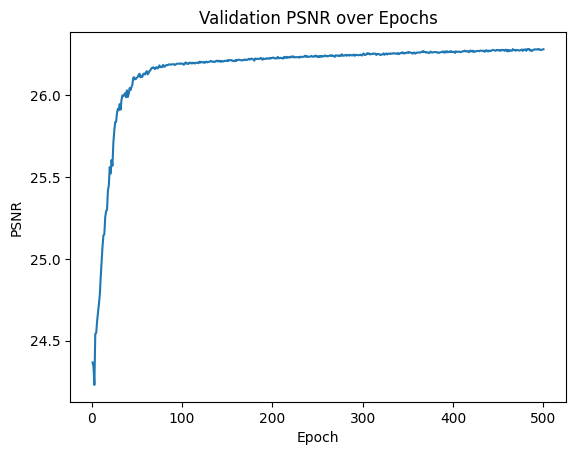

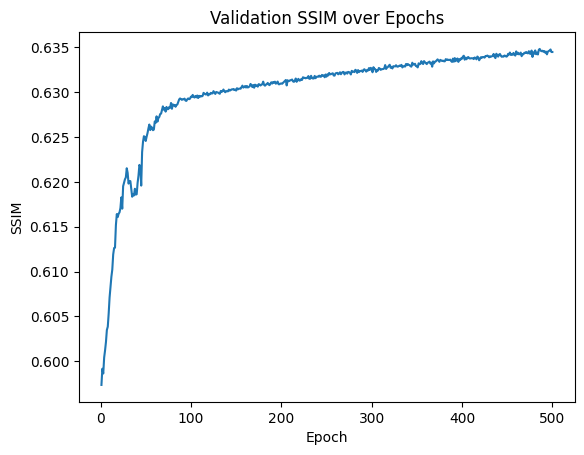

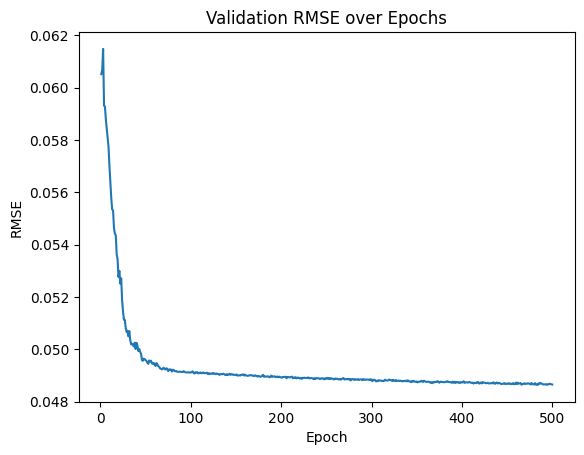

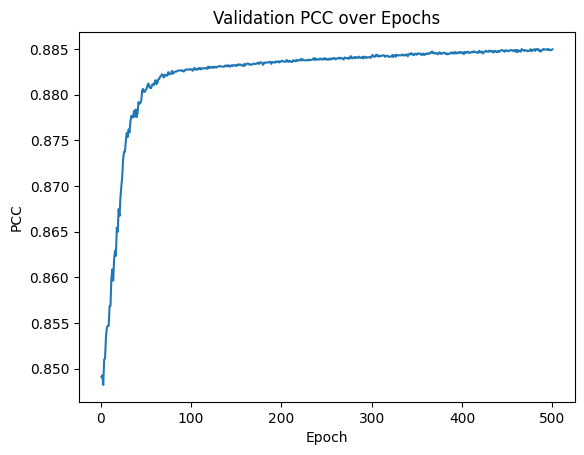

In [7]:
def main():
    if torch.cuda.is_available():
        print("CUDA is available!")
        print(f"Number of available GPUs: {torch.cuda.device_count()}")
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    else:
        print("CUDA is not available.")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DCNet(
        in_channels=1,
        channels=180,
        rg_depths=[1,1,1], #Gs × 2 DCBs = 10 blocks
        num_heads=[6,6,6],
        mlp_ratio=2.0,
        window_size=(4,4),
        scale_factors=[4],
        out_channels=1
    )

    transform_lr = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0,), (1.0,))
    ])

    transform_hr = transforms.Compose([
        transforms.ToTensor(),

    ])

    # Load the dataset
    lr_dir = "/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/dataset sdo patches low res"
    hr_dir = "/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/dataset sdo patches"

    full_dataset = SuperResolutionDataset(
        lr_dir=lr_dir,
        hr_dir=hr_dir,
        lr_transform=transform_lr,
        hr_transform=transform_hr
    )


    # Splitting the dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_loader, val_loader = dataloaders(train_dataset, val_dataset, batch_size=4, num_train_samples=None, num_val_samples=None)
    # print(summary(
    # model, 
    # input_size=(1, 1, 64, 64),  # Batch size = 1, Channels = 1, Height = 64, Width = 64
    # device=device, 
    # col_names=["input_size", "output_size", "num_params", "trainable"], 
    # depth=4
    # ))
    setup_training(model, device, train_loader, val_loader)

main()


In [8]:
!nvidia-smi

Sat Jun 21 10:55:48 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:1A:00.0  On |                  Off |
| 70%   80C    P2             132W / 300W |  13331MiB / 49140MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Testing

In [9]:
model = DCNet(
        in_channels=1,
        channels=180,
        rg_depths=[2,2,2,2,2],   # 5 RGs × 2 DCBs = 10 blocks
        num_heads=[6,6,6,6,6],
        mlp_ratio=2.0,
        window_size=(4,4),
        scale_factors=[4],
        out_channels=1
    ).to(device)
model.load_state_dict(torch.load("/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/anubhav/DCNET/Resolution_Enhancement_DCNET-main/Resolution_Enhancement_DCNET/Architecture/models/20250611_173045/model_epoch100.pth"))
# model.eval()


/tmp/ipykernel_828878/2460794555.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user

<All keys matched successfully>

In [10]:
# from predict import prediction
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0,], std=[1,])
    # transforms.Lambda(lambda x: x * 255.0),
])

def prediction(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image)
    return output.squeeze(0).cpu()


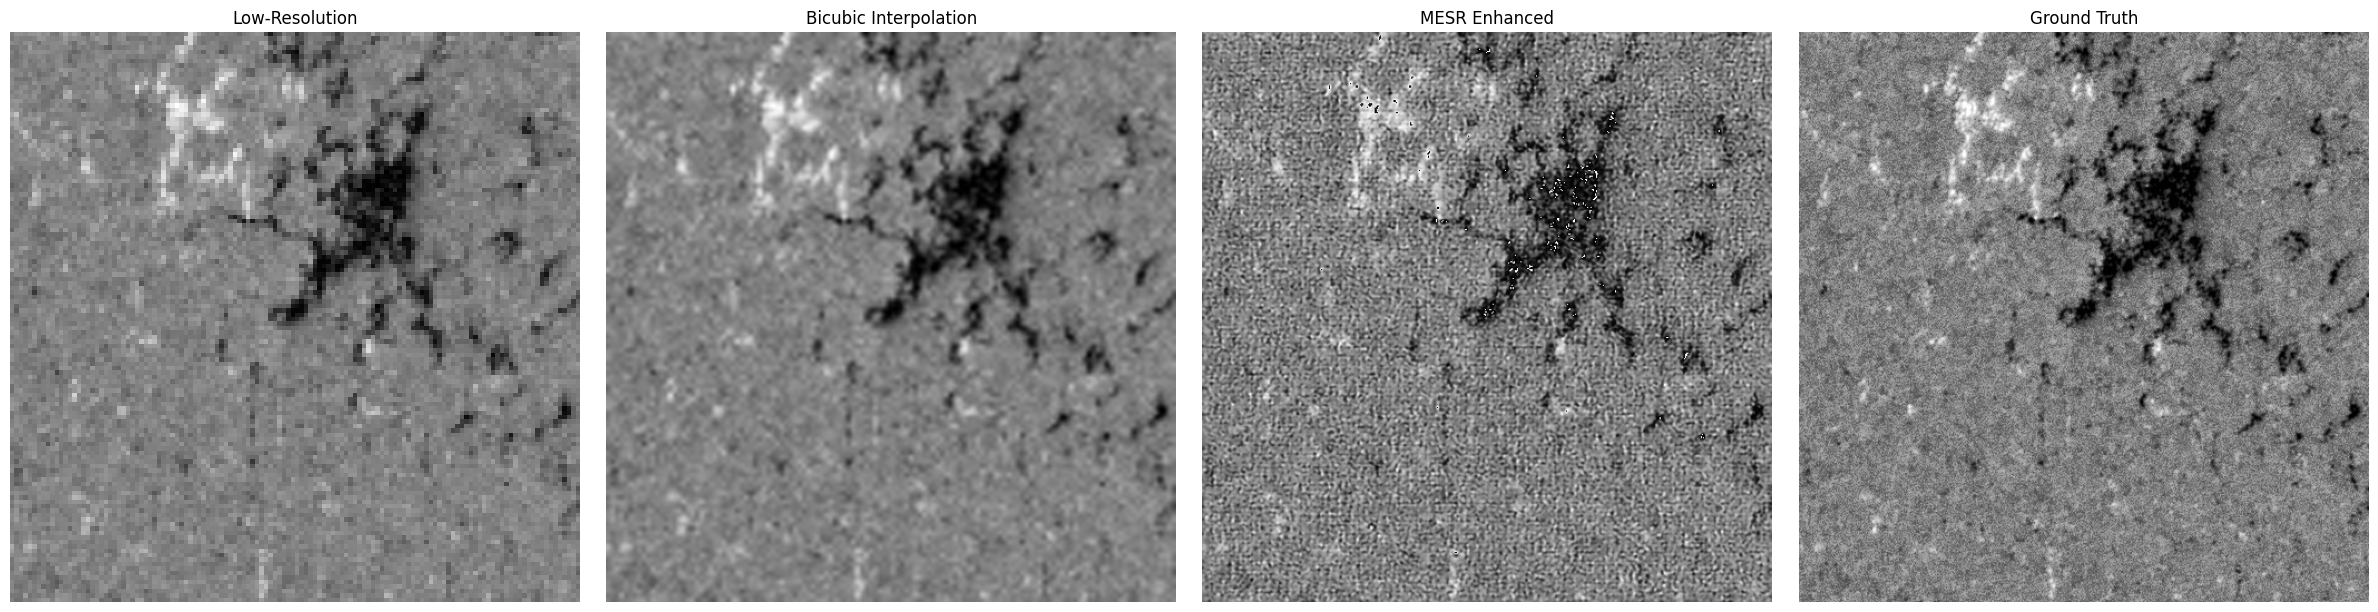

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import cv2

# Example usage with visualization
low_res_image_path = '/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM NEW NEW/RESM/20100903_0025_hr_patch_11.jpg'  # Replace with your low-res image path
hr_image_path = '/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/dataset sdo patches/20100903_0025_hr_patch_11.jpg'  # Replace with your high-res image path

# Get SRCNN/MESR enhanced image
predicted_image_tensor = prediction(model, low_res_image_path)
predicted_image_pil = transforms.ToPILImage()(predicted_image_tensor)  # Convert tensor to PIL image
predicted_image_np = np.array(predicted_image_pil)  # Convert PIL to NumPy array

# Load low-resolution image
low_res_pil = Image.open(low_res_image_path).convert('L')
low_res_np = np.array(low_res_pil)

# Load ground truth high-resolution image
hr_pil = Image.open(hr_image_path).convert('L')
hr_np = np.array(hr_pil)

# Perform bicubic interpolation
bicubic_np = cv2.resize(low_res_np, (predicted_image_np.shape[1], predicted_image_np.shape[0]), interpolation=cv2.INTER_CUBIC)

# Visualization using matplotlib
plt.figure(figsize=(24, 6))  # Adjust figure size as needed

# Subplot 1: Low-Resolution Image
plt.subplot(1, 4, 1)
plt.imshow(low_res_np, cmap='gray')
plt.title('Low-Resolution')
plt.axis('off')

# Subplot 2: Bicubic Interpolation Image
plt.subplot(1, 4, 2)
plt.imshow(bicubic_np, cmap='gray')
plt.title('Bicubic Interpolation')
plt.axis('off')

# Subplot 3: MESR Enhanced Image
plt.subplot(1, 4, 3)
plt.imshow(predicted_image_np, cmap='gray')
plt.title('MESR Enhanced')
plt.axis('off')

# Subplot 4: Ground Truth (High-Resolution) Image
plt.subplot(1, 4, 4)
plt.imshow(hr_np, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optionally save the images
predicted_image_pil.save('path_to_save_predicted_image.png')
bicubic_pil = Image.fromarray(bicubic_np)
bicubic_pil.save('path_to_save_bicubic_image.png')
hr_pil.save('path_to_save_hr_image.png')


In [12]:
predicted_image_tensor

tensor([[[0.4910, 0.5490, 0.6049,  ..., 0.5827, 0.5973, 0.6031],
         [0.4596, 0.4666, 0.5285,  ..., 0.4566, 0.5348, 0.5820],
         [0.3993, 0.3669, 0.4162,  ..., 0.3549, 0.4883, 0.5517],
         ...,
         [0.4781, 0.4868, 0.5352,  ..., 0.6122, 0.5580, 0.4686],
         [0.4701, 0.4638, 0.4942,  ..., 0.6158, 0.5421, 0.4708],
         [0.4478, 0.4331, 0.4450,  ..., 0.5656, 0.5113, 0.4942]]])